特征选择(排序)对于数据科学家、机器学习从业者来说非常重要。好的特征选择能够提升模型的性能，更能帮助我们理解数据的特点、底层结构，这对进一步改善模型、算法都有着重要作用。特征选择主要有两个功能：减少特征数量、降维，使模型泛化能力更强，减少过拟合增强对特征和特征值之间的理解拿到数据集，一个特征选择方法，往往很难同时完成这两个目的。通常情况下，我们经常不管三七二十一，选择一种自己最熟悉或者最方便的特征选择方法（往往目的是降维，而忽略了对特征和数据理解的目的）。在许多机器学习相关的书里，很难找到关于特征选择的内容，因为特征选择要解决的问题往往被视为机器学习的一种副作用，一般不会单独拿出来讨论。




## 1 去掉取值变化小(信息量小）的特征 Removing features with low variance

这应该是最简单的特征选择方法了：假设某特征的特征值只有0和1，并且在所有输入样本中，95%的实例的该特征取值都是1，那就可以认为这个特征作用不大。如果100%都是1，那这个特征就没意义了。当特征值都是离散型变量的时候这种方法才能用，如果是连续型变量，就需要将连续变量离散化之后才能用，而且实际当中，一般不太会有95%以上都取某个值的特征存在，所以这种方法虽然简单但是不太好用。可以把它作为特征选择的预处理，先去掉那些取值变化小的特征，然后再从接下来提到的的特征选择方法中选择合适的进行进一步的特征选择。


In [57]:
from sklearn.feature_selection import VarianceThreshold
 
#方差选择法，返回值为特征选择后的数据
#参数threshold为方差的阈值
a = VarianceThreshold(threshold=0.1).fit_transform(iris.data)
b = VarianceThreshold(threshold=0.5).fit_transform(iris.data)
print(a[:5])
print(b[:5])

#方差过小即取值接近一样，可以用方差法筛选连续特征， count（） groupby筛选离散特征

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
[[5.1 1.4 0.2]
 [4.9 1.4 0.2]
 [4.7 1.3 0.2]
 [4.6 1.5 0.2]
 [5.  1.4 0.2]]


## 2 单变量特征选择 Univariate feature selection

单变量特征选择能够对每一个特征进行测试，衡量该特征和响应变量之间的关系，根据得分扔掉不好的特征。对于回归和分类问题可以采用卡方检验等方式对特征进行测试。这种方法比较简单，易于运行，易于理解，通常对于理解数据有较好的效果（但对特征优化、提高泛化能力来说不一定有效）；这种方法有许多改进的版本、变种。



## 2.1皮尔逊相关系数
皮尔森相关系数是一种最简单的，能帮助理解特征和响应变量之间关系的方法，该方法衡量的是变量之间的线性相关性，结果的取值区间为[-1，1]，-1表示完全的负相关(这个变量下降，那个就会上升)，+1表示完全的正相关，0表示没有线性相关。Pearson Correlation速度快、易于计算，经常在拿到数据(经过清洗和特征提取之后的)之后第一时间就执行。Scipy的pearsonr方法能够同时计算相关系数和p-value，



In [3]:
import numpy as np
from scipy.stats import pearsonr
np.random.seed(4)
size = 300
x = np.random.normal(0, 1, size)
print( "Lower noise", pearsonr(x, x + np.random.normal(0, 1, size)))
print( "Higher noise", pearsonr(x, x + np.random.normal(0, 10, size)))
#这个例子中，我们比较了变量在加入噪音之前和之后的差异。当噪音比较小的时候，相关性很强，p-value很低

Lower noise (0.7270649532852493, 1.3596948125051596e-50)
Higher noise (0.12664606407000215, 0.02828899705921323)


缺点：Pearson相关系数的一个明显缺陷是，作为特征排序机制，他只对线性关系敏感。如果关系是非线性的，即便两个变量具有一一对应的关系，Pearson相关性也可能会接近0。

In [6]:
x = np.random.uniform(-1, 1, 100000)
print( pearsonr(x, x**2)[0])
print(x)
print(x**2)

-0.003726086649444559
[ 0.57015514 -0.67072523  0.55734183 ... -0.57532697 -0.54593222
  0.11249746]
[0.32507688 0.44987234 0.31062991 ... 0.33100113 0.29804199 0.01265568]


## 2.2 互信息和最大信息系数 Mutual information and maximal information coefficient (MIC)

以上就是经典的互信息公式了。想把互信息直接用于特征选择其实不是太方便：1、它不属于度量方式，也没有办法归一化，在不同数据及上的结果无法做比较；2、对于连续变量的计算不是很方便（X和Y都是集合，x，y都是离散的取值），通常变量需要先离散化，而互信息的结果对离散化的方式很敏感。最大信息系数克服了这两个问题。它首先寻找一种最优的离散化方式，然后把互信息取值转换成一种度量方式，取值区间在[0，1]。minepy提供了MIC功能。反过头来看y=x^2这个例子，MIC算出来的互信息值为1(最大的取值)。



In [11]:
from minepy import MINE
m = MINE()
x = np.random.uniform(-1, 1, 10000)
m.compute_score(x, x**2+np.random.normal(0,0.1,10000))
print( m.mic())


0.778881464371471


## 2.3 距离相关系数 (Distance correlation)
距离相关系数是为了克服Pearson相关系数的弱点而生的。在x和x^2这个例子中，即便Pearson相关系数是0，我们也不能断定这两个变量是独立的（有可能是非线性相关）；但如果距离相关系数是0，那么我们就可以说这两个变量是独立的。

0.021189031439749022 0.23051992476158456 0.17849137776786192 0.04733561571533031
0.014612967111948975 0.06210319362896604 0.17849137776786192 0.3101927932494554
0.011868725405189729 0.038310830847283005 0.3094092687489433 0.3101927932494554
0.001311566873843021 0.004207046841521612 0.31332458981728684 0.3101927932494554


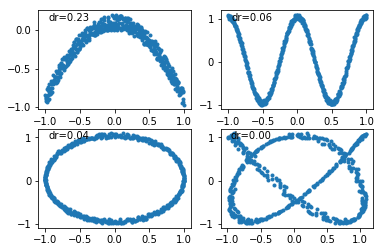

In [14]:
# -*- coding: utf-8 -*-
#网上的一个实现
"""
Created on Fri Jun 15 14:00:29 2012
Author: Josef Perktold
License: MIT, BSD-3 (for statsmodels)
http://en.wikipedia.org/wiki/Distance_correlation
Yaroslav and Satrajit on sklearn mailing list
Univariate only, distance measure is just absolute distance
Note: Same as R package energy DCOR, except DCOR reports sqrt of all returns of dcov_all
"""

import numpy as np


def dist(x, y):
    #1d only
    return np.abs(x[:, None] - y)
    

def d_n(x):
    d = dist(x, x)
    dn = d - d.mean(0) - d.mean(1)[:,None] + d.mean()
    return dn


def dcov_all(x, y):
    dnx = d_n(x)
    dny = d_n(y)
    
    denom = np.product(dnx.shape)
    dc = (dnx * dny).sum() / denom
    dvx = (dnx**2).sum() / denom
    dvy = (dny**2).sum() / denom
    dr = dc / (np.sqrt(dvx) * np.sqrt(dvy))
    return dc, dr, dvx, dvy


import matplotlib.pyplot as plt

fig = plt.figure()
for case in range(1,5):

    np.random.seed(9854673)
    x = np.linspace(-1,1, 501)
    if case == 1:
        y = - x**2 + 0.2 * np.random.rand(len(x))
    elif case == 2:
        y = np.cos(x*2*np.pi) + 0.1 * np.random.rand(len(x))
    elif case == 3:
        x = np.sin(x*2*np.pi) + 0.0 * np.random.rand(len(x))  #circle
    elif case == 4:
        x = np.sin(x*1.5*np.pi) + 0.1 * np.random.rand(len(x))  #bretzel
    dc, dr, dvx, dvy = dcov_all(x, y)
    print (dc, dr, dvx, dvy)
    
    ax = fig.add_subplot(2,2, case)
    #ax.set_xlim(-1, 1)
    ax.plot(x, y, '.')
    yl = ax.get_ylim()
    ax.text(-0.95, yl[0] + 0.9 * np.diff(yl), 'dr=%4.2f' % dr)

plt.show()

尽管有MIC和距离相关系数在了，但当变量之间的关系接近线性相关的时候，Pearson相关系数仍然是不可替代的。第一、Pearson相关系数计算速度快，这在处理大规模数据的时候很重要。第二、Pearson相关系数的取值区间是[-1，1]，而MIC和距离相关系数都是[0，1]。这个特点使得Pearson相关系数能够表征更丰富的关系，符号表示关系的正负，绝对值能够表示强度。当然，Pearson相关性有效的前提是两个变量的变化关系是单调的。


## 2.4 基于学习模型的特征排序 (Model based ranking)

这种方法的思路是直接使用你要用的机器学习算法，针对每个单独的特征和响应变量建立预测模型。其实Pearson相关系数等价于线性回归里的标准化回归系数。假如某个特征和响应变量之间的关系是非线性的，可以用基于树的方法（决策树、随机森林）、或者扩展的线性模型等。基于树的方法比较易于使用，因为他们对非线性关系的建模比较好，并且不需要太多的调试。但要注意过拟合问题，因此树的深度最好不要太大，再就是运用交叉验证。



In [18]:
#运用RF得到特征重要性

from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
 
#Load boston housing dataset as an example
boston = load_boston()
X = boston["data"]
Y = boston["target"]
names = boston["feature_names"]
 
rf = RandomForestRegressor(n_estimators=200, max_depth=5)
scores = []
for i in range(X.shape[1]):
     score = cross_val_score(rf, X[:, i:i+1], Y, scoring="r2",
                              cv=ShuffleSplit(len(X), 3, .3))
     scores.append((round(np.mean(score), 3), names[i]))
print (sorted(scores, reverse=True))


[(0.623, 'LSTAT'), (0.55, 'RM'), (0.473, 'NOX'), (0.339, 'INDUS'), (0.31, 'TAX'), (0.288, 'PTRATIO'), (0.176, 'CRIM'), (0.168, 'RAD'), (0.148, 'B'), (0.121, 'ZN'), (0.104, 'DIS'), (0.049, 'AGE'), (-0.019, 'CHAS')]


## 3 线性模型和正则化
单变量特征选择方法独立的衡量每个特征与响应变量之间的关系，另一种主流的特征选择方法是基于机器学习模型的方法。有些机器学习方法本身就具有对特征进行打分的机制，或者很容易将其运用到特征选择任务中，例如回归模型，SVM，决策树，随机森林等等。说句题外话，这种方法好像在一些地方叫做wrapper类型，大概意思是说，特征排序模型和机器学习模型是耦盒在一起的，对应的非wrapper类型的特征选择方法叫做filter类型。



下面将介绍如何用回归模型的系数来选择特征。越是重要的特征在模型中对应的系数就会越大，而跟输出变量越是无关的特征对应的系数就会越接近于0。在噪音不多的数据上，或者是数据量远远大于特征数的数据上，如果特征之间相对来说是比较独立的，那么即便是运用最简单的线性回归模型也一样能取得非常好的效果。



In [19]:
from sklearn.linear_model import LinearRegression
import numpy as np
 
np.random.seed(0)
size = 5000
 
#A dataset with 3 features
X = np.random.normal(0, 1, (size, 3))
#Y = X0 + 2*X1 + noise
Y = X[:,0] + 2*X[:,1] + np.random.normal(0, 2, size)
lr = LinearRegression()
lr.fit(X, Y)
 
#A helper method for pretty-printing linear models
def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)
 
print ("Linear model:", pretty_print_linear(lr.coef_))


Linear model: 0.984 * X0 + 1.995 * X1 + -0.041 * X2


在这个例子当中，尽管数据中存在一些噪音，但这种特征选择模型仍然能够很好的体现出数据的底层结构。当然这也是因为例子中的这个问题非常适合用线性模型来解：特征和响应变量之间全都是线性关系，并且特征之间均是独立的

在很多实际的数据当中，往往存在多个互相关联的特征，这时候模型就会变得不稳定，数据中细微的变化就可能导致模型的巨大变化（模型的变化本质上是系数，或者叫参数，可以理解成W），这会让模型的预测变得困难，这种现象也称为多重共线性。例如，假设我们有个数据集，它的真实模型应该是Y=X1+X2，当我们观察的时候，发现Y’=X1+X2+e，e是噪音。如果X1和X2之间存在线性关系，例如X1约等于X2，这个时候由于噪音e的存在，我们学到的模型可能就不是Y=X1+X2了，有可能是Y=2X1，或者Y=-X1+3X2。



In [20]:
#下边这个例子当中，在同一个数据上加入了一些噪音，用随机森林算法进行特征选择。
from sklearn.linear_model import LinearRegression
 
size = 100
np.random.seed(seed=5)
 
X_seed = np.random.normal(0, 1, size)
X1 = X_seed + np.random.normal(0, .1, size)
X2 = X_seed + np.random.normal(0, .1, size)
X3 = X_seed + np.random.normal(0, .1, size)
 
Y = X1 + X2 + X3 + np.random.normal(0,1, size)
X = np.array([X1, X2, X3]).T
 
lr = LinearRegression()
lr.fit(X,Y)
print ("Linear model:", pretty_print_linear(lr.coef_))


Linear model: -1.291 * X0 + 1.591 * X1 + 2.747 * X2


系数之和接近3，基本上和上上个例子的结果一致，应该说学到的模型对于预测来说还是不错的。但是，如果从系数的字面意思上去解释特征的重要性的话，X3对于输出变量来说具有很强的正面影响，而X1具有负面影响，而实际上所有特征与输出变量之间的影响是均等的。同样的方法和套路可以用到类似的线性模型上，比如逻辑回归。



## 3.2正则化

In [22]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston
 
boston = load_boston()
scaler = StandardScaler()
X = scaler.fit_transform(boston["data"])
Y = boston["target"]
names = boston["feature_names"]
 
lasso = Lasso(alpha=.3)
lasso.fit(X, Y)
 
print ("Lasso model: ", lasso.coef_, names)

#趋向于0的正则化 L1


Lasso model:  [-0.23616802  0.08100299 -0.          0.54017417 -0.70027816  2.99189989
 -0.         -1.08067403  0.         -0.         -1.75682067  0.63108483
 -3.70696598] ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [24]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston
 
boston = load_boston()
scaler = StandardScaler()
X = scaler.fit_transform(boston["data"])
Y = boston["target"]
names = boston["feature_names"]
 
lasso = Lasso(alpha=1.3)
lasso.fit(X, Y)
 
print ("Lasso model: ", lasso.coef_, names)

#趋向于0的正则化 L1---进一步增大alpha，增大正则力度，更多的0


Lasso model:  [-0.          0.         -0.          0.         -0.          2.53639988
 -0.         -0.         -0.         -0.         -1.15959658  0.
 -3.48704991] ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


L2：

L2正则化将系数向量的L2范数添加到了损失函数中。由于L2惩罚项中系数是二次方的，这使得L2和L1有着诸多差异，最明显的一点就是，L2正则化会让系数的取值变得平均。对于关联特征，这意味着他们能够获得更相近的对应系数。还是以Y=X1+X2为例，假设X1和X2具有很强的关联，如果用L1正则化，不论学到的模型是Y=X1+X2还是Y=2X1，惩罚都是一样的，都是2alpha。但是对于L2来说，第一个模型的惩罚项是2alpha，但第二个模型的是4*alpha。可以看出，系数之和为常数时，各系数相等时惩罚是最小的，所以才有了L2会让各个系数趋于相同的特点。可以看出，L2正则化对于特征选择来说一种稳定的模型，不像L1正则化那样，系数会因为细微的数据变化而波动。所以L2正则化和L1正则化提供的价值是不同的，L2正则化对于特征理解来说更加有用：表示能力强的特征对应的系数是非零



In [28]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
size = 100
 
#We run the method 10 times with different random seeds
for i in range(10):
    print ("Random seed %s" % i)
    np.random.seed(seed=i)
    X_seed = np.random.normal(0, 1, size)
    X1 = X_seed + np.random.normal(0, .1, size)
    X2 = X_seed + np.random.normal(0, .1, size)
    X3 = X_seed + np.random.normal(0, .1, size)
    Y = X1 + X2 + X3 + np.random.normal(0, 1, size)
    X = np.array([X1, X2, X3]).T
 
 
    lr = LinearRegression()
    lr.fit(X,Y)
    print ("Linear model:", (lr.coef_))
 
    ridge = Ridge(alpha=10)
    ridge.fit(X,Y)
    print ("Ridge model:", (ridge.coef_))


Random seed 0
Linear model: [ 0.7284403   2.30926001 -0.08219169]
Ridge model: [0.93832131 1.05887277 0.87652644]
Random seed 1
Linear model: [ 1.15181561  2.36579916 -0.59900864]
Ridge model: [0.98409577 1.06792673 0.75855367]
Random seed 2
Linear model: [0.69734749 0.32155864 2.08590886]
Ridge model: [0.97159124 0.94256202 1.08539406]
Random seed 3
Linear model: [0.28735446 1.25386129 1.49054726]
Ridge model: [0.91891806 1.00474386 1.03276594]
Random seed 4
Linear model: [0.18726691 0.77214206 2.1894915 ]
Ridge model: [0.96401621 0.98152524 1.0983599 ]
Random seed 5
Linear model: [-1.2912413   1.59097473  2.74727029]
Ridge model: [0.75819864 1.01085804 1.1390417 ]
Random seed 6
Linear model: [ 1.19909595 -0.0306915   1.91454912]
Ridge model: [1.01616507 0.89032238 1.0907386 ]
Random seed 7
Linear model: [ 1.47386769  1.76236014 -0.15057274]
Ridge model: [1.0179376  1.03865514 0.90082373]
Random seed 8
Linear model: [0.0840547  1.87985845 1.10688887]
Ridge model: [0.90685834 1.0711975

可以看出，不同的数据上线性回归得到的模型（系数）相差甚远，但对于L2正则化模型来说，结果中的系数非常的稳定，差别较小，都比较接近于1，能够反映出数据的内在结构。

##  4.随机森林


## 4.1 平均不纯度减少 
mean decrease impurity随机森林由多个决策树构成。决策树中的每一个节点都是关于某个特征的条件，为的是将数据集按照不同的响应变量一分为二。利用不纯度可以确定节点（最优条件），对于分类问题，通常采用基尼不纯度或者信息增益，对于回归问题，通常采用的是方差或者最小二乘拟合。当训练决策树的时候，可以计算出每个特征减少了多少树的不纯度。对于一个决策树森林来说，可以算出每个特征平均减少了多少不纯度，并把它平均减少的不纯度作为特征选择的值。下边的例子是sklearn中基于随机森林的特征重要度度量方法：



In [44]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
import numpy as np
#Load boston housing dataset as an example
boston = load_boston()
X = boston["data"]
Y = boston["target"]
names = boston["feature_names"]
rf = RandomForestRegressor()
rf.fit(X, Y)
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))


Features sorted by their score:
[(0.4408, 'LSTAT'), (0.3644, 'RM'), (0.0594, 'DIS'), (0.0463, 'CRIM'), (0.0228, 'NOX'), (0.0172, 'B'), (0.0141, 'TAX'), (0.0136, 'PTRATIO'), (0.0093, 'AGE'), (0.0062, 'INDUS'), (0.003, 'RAD'), (0.0024, 'ZN'), (0.0005, 'CHAS')]


缺点：需要注意的一点是，关联特征的打分存在不稳定的现象，这不仅仅是随机森林特有的，大多数基于模型的特征选择方法都存在这个问题。

可自行观察上述代码多次运行后输出的顺序

## 4.2 平均精确率减少 Mean decrease accuracy

另一种常用的特征选择方法就是直接度量每个特征对模型精确率的影响。主要思路是打乱每个特征的特征值顺序，并且度量顺序变动对模型的精确率的影响。很明显，对于不重要的变量来说，打乱顺序对模型的精确率影响不会太大，但是对于重要的变量来说，打乱顺序就会降低模型的精确率。这个方法sklearn中没有直接提供，但是很容易实现，下面继续在波士顿房价数据集上进行实现。



In [46]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict
 
X = boston["data"]
Y = boston["target"]
 
rf = RandomForestRegressor()
scores = defaultdict(list)
 
#crossvalidate the scores on a number of different random splits of the data
for train_idx, test_idx in ShuffleSplit(len(X), 100, .3):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    r = rf.fit(X_train, Y_train)
    acc = r2_score(Y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(Y_test, rf.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)
print ("Features sorted by their score:")
print (sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))


Features sorted by their score:
[(0.7285, 'LSTAT'), (0.5754, 'RM'), (0.081, 'DIS'), (0.0412, 'NOX'), (0.0408, 'CRIM'), (0.0209, 'PTRATIO'), (0.0172, 'TAX'), (0.0108, 'AGE'), (0.0059, 'INDUS'), (0.0052, 'B'), (0.0032, 'RAD'), (0.0005, 'CHAS'), (0.0003, 'ZN')]


在这个例子当中，LSTAT和RM这两个特征对模型的性能有着很大的影响，打乱这两个特征的特征值使得模型的性能下降了73%和57%。注意，尽管这些我们是在所有特征上进行了训练得到了模型，然后才得到了每个特征的重要性测试，这并不意味着我们扔掉某个或者某些重要特征后模型的性能就一定会下降很多，因为即便某个特征删掉之后，其关联特征一样可以发挥作用，让模型性能基本上不变。



## 5 两种顶层特征选择算法
之所以叫做顶层，是因为他们都是建立在基于模型的特征选择方法基础之上的，例如回归和SVM，在不同的子集上建立模型，然后汇总最终确定特征得分。

### 5.1 稳定性选择 Stability selection-- 如多次Lasso后汇总权重的结果

稳定性选择是一种基于二次抽样和选择算法相结合较新的方法，选择算法可以是回归、SVM或其他类似的方法。它的主要思想是在不同的数据子集和特征子集上运行特征选择算法，不断的重复，最终汇总特征选择结果，比如可以统计某个特征被认为是重要特征的频率（被选为重要特征的次数除以它所在的子集被测试的次数）。理想情况下，重要特征的得分会接近100%。稍微弱一点的特征得分会是非0的数，而最无用的特征得分将会接近于0。



In [33]:
from sklearn.linear_model import RandomizedLasso
from sklearn.datasets import load_boston
boston = load_boston()
 
#using the Boston housing data. 
#Data gets scaled automatically by sklearn's implementation
X = boston["data"]
Y = boston["target"]
names = boston["feature_names"]
 
rlasso = RandomizedLasso(alpha=0.025)
rlasso.fit(X, Y)
 
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
                 names), reverse=True))


C:\Users\tianjiayang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


Features sorted by their score:
[(1.0, 'RM'), (1.0, 'PTRATIO'), (1.0, 'LSTAT'), (0.63, 'B'), (0.565, 'CHAS'), (0.37, 'TAX'), (0.365, 'CRIM'), (0.24, 'DIS'), (0.205, 'NOX'), (0.16, 'INDUS'), (0.04, 'ZN'), (0.015, 'RAD'), (0.0, 'AGE')]


在上边这个例子当中，最高的3个特征得分是1.0，这表示他们总会被选作有用的特征（当然，得分会收到正则化参数alpha的影响，但是sklearn的随机lasso能够自动选择最优的alpha）。接下来的几个特征得分就开始下降，但是下降的不是特别急剧，这跟纯lasso的方法和随机森林的结果不一样。能够看出稳定性选择对于克服过拟合和对数据理解来说都是有帮助的：总的来说，好的特征不会因为有相似的特征、关联特征而得分为0，这跟Lasso是不同的。对于特征选择任务，在许多数据集和环境下，稳定性选择往往是性能最好的方法之一。


### 5.2 递归特征消除 Recursive feature elimination (RFE)

递归特征消除的主要思想是反复的构建模型（如SVM或者回归模型）然后选出最好的（或者最差的）的特征（可以根据系数来选），把选出来的特征放到一遍，然后在剩余的特征上重复这个过程，直到所有特征都遍历了。这个过程中特征被消除的次序就是特征的排序。因此，这是一种寻找最优特征子集的贪心算法。RFE的稳定性很大程度上取决于在迭代的时候底层用哪种模型。例如，假如RFE采用的普通的回归，没有经过正则化的回归是不稳定的，那么RFE就是不稳定的；假如采用的是Ridge，而用Ridge正则化的回归是稳定的，那么RFE就是稳定的。Sklearn提供了RFE包，可以用于特征消除，还提供了RFECV，可以通过交叉验证来对的特征进行排序。


In [35]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
 
boston = load_boston()
X = boston["data"]
Y = boston["target"]
names = boston["feature_names"]
 
#use linear regression as the model
lr = LinearRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X,Y)
 
print ("Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))


Features sorted by their rank:
[(1, 'NOX'), (2, 'RM'), (3, 'CHAS'), (4, 'PTRATIO'), (5, 'DIS'), (6, 'LSTAT'), (7, 'RAD'), (8, 'CRIM'), (9, 'INDUS'), (10, 'ZN'), (11, 'TAX'), (12, 'B'), (13, 'AGE')]


## 6 一个完整的例子下面将本文所有提到的方法进行实验对比，
数据集采用Friedman #1 

回归数据（这篇论文中的数据）。

数据是用这个公式产生的：

X1到X5是由单变量分布生成的，e是标准正态变量N(0,1)。另外，原始的数据集中含有5个噪音变量 X5,…,X10，跟响应变量是独立的。我们增加了4个额外的变量X11,…X14，分别是X1,…,X4的关联变量，通过f(x)=x+N(0,0.01)生成，这将产生大于0.999的关联系数。这样生成的数据能够体现出不同的特征排序方法应对关联特征时的表现。接下来将会在上述数据上运行所有的特征选择方法，并且将每种方法给出的得分进行归一化，让取值都落在0-1之间。对于RFE来说，由于它给出的是顺序而不是得分，我们将最好的5个的得分定为1，其他的特征的得分均匀的分布在0-1之间。



特征之间存在线性关联关系，每个特征都是独立评价的，因此X1,…X4的得分和X11,…X14的得分非常接近，而噪音特征X5,…,X10正如预期的那样和响应变量之间几乎没有关系。

由于变量X3是二次的，因此X3和响应变量之间看不出有关系（除了MIC之外，其他方法都找不到关系）。

这种方法能够衡量出特征和响应变量之间的线性关系，但若想选出优质特征来提升模型的泛化能力，这种方法就不是特别给力了，因为所有的优质特征都不可避免的会被挑出来两次。

Lasso能够挑出一些优质特征，同时让其他特征的系数趋于0。当如需要减少特征数的时候它很有用，但是对于数据理解来说不是很好用。

（例如在结果表中，X11,X12,X13的得分都是0，好像他们跟输出变量之间没有很强的联系，但实际上不是这样的）

MIC对特征一视同仁，这一点上和关联系数有点像，另外，它能够找出X3和响应变量之间的非线性关系。

随机森林基于不纯度的排序结果非常鲜明，在得分最高的几个特征之后的特征，得分急剧的下降。

从表中可以看到，得分第三的特征比第一的小4倍。而其他的特征选择算法就没有下降的这么剧烈。

Ridge将回归系数均匀的分摊到各个关联变量上，从表中可以看出，X11,…,X14和X1,…,X4的得分非常接近。

稳定性选择常常是一种既能够有助于理解数据又能够挑出优质特征的这种选择，在结果表中就能很好的看出。像Lasso一样，它能找到那些性能比较好的特征（X1，X2，X4，X5），同时，与这些特征关联度很强的变量也得到了较高的得分。

## 总结

对于理解数据、数据的结构、特点来说，单变量特征选择是个非常好的选择。尽管可以用它对特征进行排序来优化模型，但由于它不能发现冗余（例如假如一个特征子集，其中的特征之间具有很强的关联，那么从中选择最优的特征时就很难考虑到冗余的问题）。

正则化的线性模型对于特征理解和特征选择来说是非常强大的工具。L1正则化能够生成稀疏的模型，对于选择特征子集来说非常有用；相比起L1正则化，L2正则化的表现更加稳定，由于有用的特征往往对应系数非零，因此L2正则化对于数据的理解来说很合适。

由于响应变量和特征之间往往是非线性关系，可以采用basis expansion的方式将特征转换到一个更加合适的空间当中，在此基础上再考虑运用简单的线性模型。

随机森林是一种非常流行的特征选择方法，它易于使用，一般不需要feature engineering、调参等繁琐的步骤，并且很多工具包都提供了平均不纯度下降方法。它的两个主要问题，1是重要的特征有可能得分很低（关联特征问题），2是这种方法对特征变量类别多的特征越有利（偏向问题）。尽管如此，这种方法仍然非常值得在你的应用中试一试。

特征选择在很多机器学习和数据挖掘场景中都是非常有用的。在使用的时候要弄清楚自己的目标是什么，然后找到哪种方法适用于自己的任务。当选择最优特征以提升模型性能的时候，可以采用交叉验证的方法来验证某种方法是否比其他方法要好。

当用特征选择的方法来理解数据的时候要留心，特征选择模型的稳定性非常重要，稳定性差的模型很容易就会导致错误的结论。对数据进行二次采样然后在子集上运行特征选择算法能够有所帮助，如果在各个子集上的结果是一致的，那就可以说在这个数据集上得出来的结论是可信的，可以用这种特征选择模型的结果来理解数据。




In [49]:
"""1.过滤型"""
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

iris=load_iris()
X,y=iris.data,iris.target
print (X.shape)
#卡方检验
X_new=SelectKBest(chi2,k=2).fit_transform(X,y)
print (X_new.shape)

"""输出：
        (150L, 4L)
        (150L, 2L)"""

"""2.包裹型"""
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston

boston=load_boston()
X=boston["data"]
Y=boston["target"]
names=boston["feature_names"]

lr=LinearRegression()
rfe=RFE(lr,n_features_to_select=1)#选择剔除1个
rfe.fit(X,Y)

print ("features sorted by their rank:")
print (sorted(zip(map(lambda x:round(x,4), rfe.ranking_),names)))

"""输出：按剔除后AUC排名给出
features sorted by their rank:
[(1.0, 'NOX'), (2.0, 'RM'), (3.0, 'CHAS'), (4.0, 'PTRATIO'), (5.0, 'DIS'), (6.0, 'LSTAT'), (7.0, 'RAD'), (8.0, 'CRIM'), (9.0, 'INDUS'), (10.0, 'ZN'), (11.0, 'TAX')
, (12.0, 'B'), (13.0, 'AGE')]"""


"""3.嵌入型 ，老的版本没有SelectFromModel"""
from sklearn.svm import  LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

iris=load_iris()
X,y=iris.data,iris.target
print (X.shape)

lsvc=LinearSVC(C=0.01,penalty='l1',dual=False).fit(X,y)
model=SelectFromModel(lsvc,prefit=True)
X_new=model.transform(X)
print (X_new.shape)

"""输出：
            (150,4)
            (150,3)
            """



(150, 4)
(150, 2)
features sorted by their rank:
[(1, 'NOX'), (2, 'RM'), (3, 'CHAS'), (4, 'PTRATIO'), (5, 'DIS'), (6, 'LSTAT'), (7, 'RAD'), (8, 'CRIM'), (9, 'INDUS'), (10, 'ZN'), (11, 'TAX'), (12, 'B'), (13, 'AGE')]
(150, 4)
(150, 3)


'输出：\n            (150,4)\n            (150,3)\n            '